<a href="https://colab.research.google.com/github/BarbaraMcG/darwin-semantic-change/blob/main/Word_embeddings_semantic_change_Darwin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tracing meaning through time with digital methods: how did Darwin’s language evolve? -- Tuesday 8 June 2021: afternoon session

Barbara McGillivray

##License note on data

We will use the letters from the Darwin Correspondence Project (https://www.darwinproject.ac.uk/). The letters have the following license statement: http://creativecommons.org/licenses/by-nc-nd/3.0/ . Many of the texts of the letters are still in copyright to the descendants of the authors. You cannot publish the derivatives of processing these letters nor the letters themselves. The files are shared with you as participants of this course for educational purposes only.

##1. Pre-processing the Darwin corpus

I install version 4.0 of gensim:

In [89]:
!pip install gensim==4.0

Import libraries

In [203]:
import os 
from bs4 import BeautifulSoup
from google.colab import drive
import csv
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


I mount the Google drive folder. You should change the path to your Google Drive path:

In [91]:
drive.mount('/gdrive', force_remount = True) 
%ls '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Files' 


Mounted at /gdrive
letters/  Letters_text/  letters.zip  __MACOSX/  Plots/  Plots.png


I unzip the file containing all the letters. 
**This only needs to be done once** and you can skip this cell.


In [ ]:
!unzip '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Files/letters.zip' -d '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Files'

I define the name of the folder containing the unzipped files:

In [92]:
folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Files/letters'

I define the list of all files:

In [93]:
files = os.listdir(folder)

How many files are in the folder?


In [94]:
len(files)

15349

We only want xml files:

In [95]:
files = [f for f in files[:] if f.endswith(".xml")]
len(files)

15348

### Extracting the text of the letters

I create the output folder:

In [96]:
out_folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Files/Letters_text'
if not os.path.exists(out_folder):
  os.makedirs(out_folder)

We extract the trascribed text from each letter and save it in an output file.  **You can skip this cell.**

In [ ]:
outfile = open(os.path.join(out_folder, 'transcription.csv'), 'w+')
output_writer = csv.writer(outfile, delimiter = "\t")

# Write header row:
output_writer.writerow(["File", "Year", "Sender", "Receiver", "Transcription"]) 

# I initialise the variable "count" to count the files that I'm reading one by one
count = 0

# I loop over each file in the "files" list
for fname in files:
  
  # The variable "count" is incremented
  count += 1
  print("Reading file number", str(count), fname)

  # the following two lines can be commented out if we want all files
  #if count > 200:
  #  break
    
  # I open each file
  with open(os.path.join(folder, fname), "r") as infile:

    # I read the content of the file in the variable "content"
    content = infile.read()

    # Initialize the fields required (sender, receiver, date_sent, keywords, abstract, letter_text):
    sender = ""
    receiver = ""
    date_sent = "" # the date in which the letter was sent
    year = ""
    letter_text = "" # transcription of the letter  

    # I parse the XML of the file with BeautifulSoup
    soup = BeautifulSoup(content,'xml')

    # extract sender, receiver and date_sent:

    corr_action = soup.find_all("correspAction")
    if corr_action:
      # loop over all notes under "correspAction":
      for s in corr_action:
          
        #extract receiver's name:
        if s.get('type') == "received":
          try:
            receiver = s.persName.get_text()
            #print("receiver:", receiver)
          except:
            print("No receiver")

        # extract senders' name:
        if s.get('type') == "sent":
          try:
            sender = s.persName.get_text()  
            #print("sender:", sender)
          except:
            print("No sender")
            
          # extract date sent:                  
          try:
            date_sent = s.date["when"]    
            # the year is the first four characters of the date:
            year = date_sent[:4]   
          except:
            print("No date")

      # extract the transcription of the letters:
      text = soup.find_all("div")
      # I loop over all children of nodes in "div":
      for s in text:
        # I save the text of the transcription in the variable "letter_text"
        if s.get('type') == "transcription":
          letter_text = s.get_text()  
          # Remove newlines and tabs:
          letter_text = letter_text.replace("\n", " ").replace("\r", " ").replace("\t", " ").replace("  ", " ")
          # Remove leading and trailing spaces:
          letter_text = letter_text.strip()
          # test print statement:
          #print("letter_text:", letter_text)
          
      if letter_text == "":
        # If the transcription is empty, I save the variable "letter_text" with the value "TRANSCRIPTION MISSING"
        letter_text = "TRANSCRIPTION MISSING"
        # test print statement:
        #print("Tag_text:", letter_text)

      # I only select those letters for which we have a year and that were sent by or received by Charles Darwin:
      if year is not "" and (sender == "Darwin, C. R." or receiver == "Darwin, C. R.") and letter_text is not "TRANSCRIPTION MISSING":
        # write to output file
        output_writer.writerow([fname, year, sender, receiver, letter_text])
      else:
        print("missing corr_action")                 
      
outfile.close()

I define a dataframe from the csv file:

In [97]:
df = pd.read_csv(os.path.join(out_folder, 'transcription.csv'), sep = "\t")

Let's inspect the first 5 lines:

In [98]:
print(df.head(5))

                File  ...                                      Transcription
0  DCP-LETT-7806.xml  ...  Very many thanks for all that you have done fo...
1   DCP-LETT-686.xml  ...  – – –Museum three—one from Dr. Richardson who ...
2  DCP-LETT-5977.xml  ...  I have been greatly interested by your last wo...
3  DCP-LETT-5963.xml  ...  several y. ago you gave me very valuable infor...
4   DCP-LETT-692.xml  ...  – Monday Morning My dear Fox When I sent off t...

[5 rows x 5 columns]


What are the names of the columns?

In [99]:
df.columns

Index(['File', 'Year', 'Sender', 'Receiver', 'Transcription'], dtype='object')

All letters sent in 1831:


In [12]:
df.loc[df['Year'] == 1831]

,File,Year,Sender,Receiver,Transcription
22,DCP-LETT-123.xml,1831,"Darwin, C. R.","Henslow, J. S.",You must have thought it very odd my not havin...
492,DCP-LETT-136.xml,1831,"Owen, F. M. (a)","Darwin, C. R.",I have this evening heard from Caroline that y...
499,DCP-LETT-122.xml,1831,"Darwin, C. R.","Darwin, S. E.",I have just received the parcel: I suppose it ...
569,DCP-LETT-120.xml,1831,"Darwin, C. R.","Fox, W. D.",When you read this you will understand why I h...
1052,DCP-LETT-121.xml,1831,"Darwin, C. R.","Whitley, C. T.",I daresay you will be surprised when you see t...
1055,DCP-LETT-135.xml,1831,"FitzRoy, Robert","Darwin, C. R.",I read the first sentence of your letter—“Befo...
1129,DCP-LETT-119.xml,1831,"Darwin, C. R.","Darwin, S. E.","Again I am going to trouble you. I suspect, if..."
1146,DCP-LETT-131.xml,1831,"Darwin, C. R.","FitzRoy, Robert",I have been hunting in several shops but have ...
1149,DCP-LETT-125.xml,1831,"Whitley, C. T.","Darwin, C. R.","Your letter, which arrived on my return from S..."
1570,DCP-LETT-124.xml,1831,"Coldstream, John","Darwin, C. R.",I was no less surprized than delighted to see ...


Number of letters per year

In [100]:
df1 = df.groupby(['Year']).count()
df1 = df1['File']
df1

Year
1821     1
1822     9
1823     2
1824     1
1825     9
        ..
1878    18
1879    14
1880    30
1881    12
1882     2
Name: File, Length: 62, dtype: int64

Visualize number of letters per year with a bar plot:

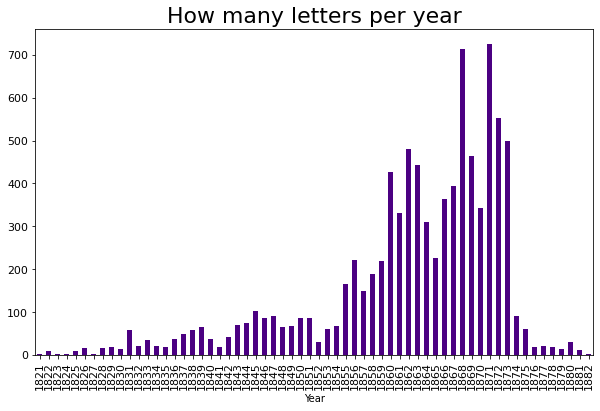

In [101]:
ax = df1.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=11);
#ax.set_alpha(0.5)
ax.set_title("How many letters per year", fontsize=22)
plt.show()

### List of scientific terms

Some letters also have a list of keywords, some of which are tagged as scientific terms. Let's create a separate list for those.

I read the letters and extract the content of the tag `term` inside `keywords`. NB: This step can take a couple of hours. **You can skip this cell.**

In [ ]:
# I initialise the list "scientific_terms" containing all keywords tagged as scientific terms:
scientific_terms = []

# I initialise the variable "count" to count the files that I'm reading one by one
count = 0

# I loop over each file in the "files" list
for fname in files:
  
  # The variable "count" is incremented
  count += 1
  print("Reading file number", str(count), fname)

  # the following two lines can be commented out if we want all files
  #if count > 20:
  #  break
    
  # I open each file
  with open(os.path.join(folder, fname), "r") as infile:

    # I read the content of the file in the variable "content"
    content = infile.read()

    # Initialize the fields required (sender, receiver, date_sent, keywords, abstract, letter_text):
    scientific_term = ""
    
    # I parse the XML of the file with BeautifulSoup
    soup = BeautifulSoup(content,'xml')

    # extract terms, which are direct children of the "keywords" tag:
    try:
      terms = soup.find("keywords").findAll("term", {"type" : "scientific_terms"}, recursive=False)
      #print(str(terms))
      if terms:
        for t in terms:
          #print("t", str(t))
          #extract scientific terms:
          try:
            scientific_term = t.get_text()
            #print("scientific term:", scientific_term)
            scientific_terms.append(scientific_term)
          except:
            print("No scientific term")
    except:
      print("No keywords")


I remove duplicates. **You can skip this cell if you skipped the previous one.**

In [ ]:
scientific_terms = set(scientific_terms)
len(scientific_terms)

I save the list to a file. **You can skip this cell if you skipped the previous ones.**

In [ ]:
# open output file:
st_outfile = open(os.path.join(out_folder, 'scientific_terms.txt'), 'w+')

for t in scientific_terms:
  st_outfile.write(t+"\n")

# close output file:
st_outfile.close()

I select single-word terms and exclude one-character strings. **You can skip this cell if you skipped the previous ones.**

In [ ]:
selected_scientific_terms = []
for t in scientific_terms:
  if " " not in t and len(t) > 1 and t is not "":
    selected_scientific_terms.append(t)
len(selected_scientific_terms)

88

Write to a file. **You can skip this cell if you skipped the previous ones.**

In [ ]:
st_outfile = open(os.path.join(out_folder, 'selected_scientific_terms.txt'), 'w+')

for t in selected_scientific_terms:
  st_outfile.write(t+"\n")

# close output file:
st_outfile.close()

Read file:

In [102]:
scientific_terms = []
st_file = open(os.path.join(out_folder, 'scientific_terms.txt'), 'r')
for line in st_file:
  term = line.strip()
  print(term)
  scientific_terms.append(term)
st_file.close()

parasites
sex differences
fertilisation and generation
endemic forms
fossils
learning and memory
exclamations
common forms
worldwide distribution
number of species
intermediate forms, gradation
mothers
behaviour
time, ‘inorganic’ (geological, historical)
cultivation
variation
divergence
scientific controversy, confrontation
shells
young, offspring
reflex behaviour
flowers and buds
sea, sea-currents
mineralogy, minerals
physical ‘external’ characters
cirripedes
vivisection
queries / requests
highness and lowness
Journal of Researches
seasons
fathers
imperfection of geological record
f
Thermometer
systematics
homology
freshwater conditions
breeding behaviour
sports
nectar
social behaviour
mongrels
pathology, disease
ice, ice-action, icebergs, glaciers
wide-ranging or mundane forms
indoor conditions
frogs
selection
number, increase and decrease
death
dispersion
introduced forms
parents
mimicry
degeneration
ammonia
transmission, ‘taking after’
ants, slave-making
aboriginal forms
os coccyx


## 2. Training word embeddings

First, I split the letters into sentences:

In [103]:
df['Transcription_sentences'] = [sent_tokenize(df['Transcription'].iloc[i]) for i in range(df.shape[0])]

Then, I tokenize the sentences:

In [104]:
df['Tokens'] = [word_tokenize(df['Transcription'].iloc[i]) for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_sentences,Tokens
0,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,[Very many thanks for all that you have done f...,"[Very, many, thanks, for, all, that, you, have..."
1,DCP-LETT-686.xml,1843,"Waterhouse, G. R.","Darwin, C. R.",– – –Museum three—one from Dr. Richardson who ...,[– – –Museum three—one from Dr. Richardson who...,"[–, –, –Museum, three—one, from, Dr., Richards..."
2,DCP-LETT-5977.xml,1868,"Peel, Jonathan","Darwin, C. R.",I have been greatly interested by your last wo...,[I have been greatly interested by your last w...,"[I, have, been, greatly, interested, by, your,..."
3,DCP-LETT-5963.xml,1868,"Darwin, C. R.","Hewitt, Edward",several y. ago you gave me very valuable infor...,[several y. ago you gave me very valuable info...,"[several, y., ago, you, gave, me, very, valuab..."
4,DCP-LETT-692.xml,1843,"Darwin, C. R.","Fox, W. D.",– Monday Morning My dear Fox When I sent off t...,[– Monday Morning My dear Fox When I sent off ...,"[–, Monday, Morning, My, dear, Fox, When, I, s..."
...,...,...,...,...,...,...,...
8902,DCP-LETT-847.xml,1845,"Darwin, C. R.","Hooker, J. D.",Down Bromley Kent March 31st My dear Hooker I ...,[Down Bromley Kent March 31st My dear Hooker I...,"[Down, Bromley, Kent, March, 31st, My, dear, H..."
8903,DCP-LETT-8292.xml,1872,"Darwin, C. R.","Bowman, William",I send by Railway today the book which you len...,[I send by Railway today the book which you le...,"[I, send, by, Railway, today, the, book, which..."
8904,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","[Dr. Hugo de Vries, who has done such excellen...","[Dr., Hugo, de, Vries, ,, who, has, done, such..."
8905,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"[I received your letter today., The larger bro...","[I, received, your, letter, today, ., The, lar..."


I exclude stopwords:

In [135]:
stopWords = set(stopwords.words('english'))
df["Tokens_nostop"] = ''
for i in range(df.shape[0]):
  df['Tokens_nostop'].iloc[i] = [t for t in df['Tokens'].iloc[i] if t not in stopWords and t not in '''!()-[]{};:\'"\,<>./?@#$%^&*_~\|–\“’`''']
df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,File,Year,Sender,Receiver,Transcription,Transcription_sentences,Tokens,Tokens_nostop
0,DCP-LETT-7806.xml,1871,"Darwin, C. R.","Darwin, Francis",Very many thanks for all that you have done fo...,[Very many thanks for all that you have done f...,"[Very, many, thanks, for, all, that, you, have...","[Very, many, thanks, done, me.—, What, earth, ..."
1,DCP-LETT-686.xml,1843,"Waterhouse, G. R.","Darwin, C. R.",– – –Museum three—one from Dr. Richardson who ...,[– – –Museum three—one from Dr. Richardson who...,"[–, –, –Museum, three—one, from, Dr., Richards...","[–Museum, three—one, Dr., Richardson, well, kn..."
2,DCP-LETT-5977.xml,1868,"Peel, Jonathan","Darwin, C. R.",I have been greatly interested by your last wo...,[I have been greatly interested by your last w...,"[I, have, been, greatly, interested, by, your,...","[I, greatly, interested, last, work, The, vari..."
3,DCP-LETT-5963.xml,1868,"Darwin, C. R.","Hewitt, Edward",several y. ago you gave me very valuable infor...,[several y. ago you gave me very valuable info...,"[several, y., ago, you, gave, me, very, valuab...","[several, y., ago, gave, valuable, information..."
4,DCP-LETT-692.xml,1843,"Darwin, C. R.","Fox, W. D.",– Monday Morning My dear Fox When I sent off t...,[– Monday Morning My dear Fox When I sent off ...,"[–, Monday, Morning, My, dear, Fox, When, I, s...","[Monday, Morning, My, dear, Fox, When, I, sent..."
...,...,...,...,...,...,...,...,...
8902,DCP-LETT-847.xml,1845,"Darwin, C. R.","Hooker, J. D.",Down Bromley Kent March 31st My dear Hooker I ...,[Down Bromley Kent March 31st My dear Hooker I...,"[Down, Bromley, Kent, March, 31st, My, dear, H...","[Down, Bromley, Kent, March, 31st, My, dear, H..."
8903,DCP-LETT-8292.xml,1872,"Darwin, C. R.","Bowman, William",I send by Railway today the book which you len...,[I send by Railway today the book which you le...,"[I, send, by, Railway, today, the, book, which...","[I, send, Railway, today, book, lent, me.—, I,..."
8904,DCP-LETT-11659.xml,1878,"Darwin, C. R.","Gray, Asa","Dr. Hugo de Vries, who has done such excellent...","[Dr. Hugo de Vries, who has done such excellen...","[Dr., Hugo, de, Vries, ,, who, has, done, such...","[Dr., Hugo, de, Vries, done, excellent, work, ..."
8905,DCP-LETT-10547.xml,1862,"Walker, Francis","Darwin, C. R.",I received your letter today. The larger brown...,"[I received your letter today., The larger bro...","[I, received, your, letter, today, ., The, lar...","[I, received, letter, today, The, larger, brow..."


I save the dataframe to a file:

In [136]:
df.to_csv(os.path.join(out_folder, 'transcription_tokens.csv'), encoding='utf-8', index = False, sep = "\t")

I train Word2Vec embeddings from the letters. **You can skip this cell.**

`min_count`: the minimum frequency threshold allowed for a word to be included

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000.

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10.

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW.


In [137]:
start = time.time()
cbow_w5_f1 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=1, vector_size=300, window = 5, sg = 0)
end = time.time()
print("It has taken", round(end - start), "seconds")

It has taken 29 seconds


In [138]:
print_vocab(cbow_w5_f1, 10)

word #0/89895 is I
word #1/89895 is one
word #2/89895 is much
word #3/89895 is would
word #4/89895 is The
word #5/89895 is think
word #6/89895 is Darwin
word #7/89895 is ”
word #8/89895 is shall


Different parameters. **You can skip this cell.**

In [139]:
start = time.time()
cbow_w5_f0 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=0, vector_size=300, window = 5, sg = 0)
end = time.time()
print("cbow_w5_f0 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f1 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=1, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f1 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f0 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=0, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f0 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f1 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=1, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f1 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f0 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=0, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f0 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f1 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=1, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f1 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f0 = gensim.models.Word2Vec(df['Tokens_nostop'], min_count=0, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f0 has taken", round(end - start), "seconds")

cbow_w5_f0 has taken 27 seconds
sg_w5_f1 has taken 94 seconds
sg_w5_f0 has taken 94 seconds
cbow_w10_f1 has taken 38 seconds
cbow_w10_f0 has taken 31 seconds
sg_w10_f1 has taken 168 seconds
sg_w10_f0 has taken 165 seconds


Skip-gram is more computationally expensive, especially with larger window sizes.

Let's save the models so we can use them later. **You can skip this cell.**

In [140]:
models_folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Models'
models = [cbow_w5_f1, cbow_w5_f0, sg_w5_f1, sg_w5_f0, cbow_w10_f1, cbow_w10_f0, sg_w10_f1, sg_w10_f0]
models_names = ["cbow_w5_f1", "cbow_w5_f0", "sg_w5_f1", "sg_w5_f0", "cbow_w10_f1", "cbow_w10_f0", "sg_w10_f1", "sg_w10_f0"]
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

Saving model number 1
Saving model number 2
Saving model number 3
Saving model number 4
Saving model number 5
Saving model number 6
Saving model number 7
Saving model number 8


Load the models:

In [141]:
models_folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Models'
cbow_w5_f1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f1"))
cbow_w5_f0 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f0"))
sg_w5_f1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f1"))
sg_w5_f0 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f0"))
cbow_w10_f1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f1"))
cbow_w10_f0 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f0"))
sg_w10_f1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f1"))
sg_w10_f0 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f0"))
models = [cbow_w5_f1, cbow_w5_f0, sg_w5_f1, sg_w5_f0, cbow_w10_f1, cbow_w10_f0, sg_w10_f1, sg_w10_f0]
models_names = ["cbow_w5_f1", "cbow_w5_f0", "sg_w5_f1", "sg_w5_f0", "cbow_w10_f1", "cbow_w10_f0", "sg_w10_f1", "sg_w10_f0"]

Let's get the embedding for the word "letter"

In [143]:
sg_w10_f0.wv['letter']

array([-0.18397954, -0.07141599, -0.30017585,  0.01487621, -0.04498456,
        0.02214292,  0.19710521,  0.4272295 , -0.0836234 , -0.12532718,
        0.19160515, -0.1527478 , -0.15143241, -0.07865976, -0.11840412,
        0.11643427,  0.09944554, -0.08078934,  0.10317131, -0.0510497 ,
        0.17745167, -0.04460474,  0.10676973, -0.3419399 ,  0.31313813,
       -0.16879477,  0.17659152, -0.41904366, -0.21974096, -0.09877728,
        0.00607262, -0.15842944, -0.10432273, -0.45936194, -0.0013976 ,
       -0.3042374 ,  0.07454883, -0.08462566, -0.16822384, -0.06485292,
        0.1289448 ,  0.23876397,  0.08351037,  0.02975919,  0.06523183,
       -0.11191062, -0.00178807, -0.02261187, -0.078087  ,  0.2623577 ,
       -0.09215809,  0.02321299, -0.18250245,  0.5314715 , -0.15813832,
        0.32321125, -0.14397544, -0.06483118, -0.13163836, -0.03393568,
        0.00197943,  0.27444053, -0.3518085 ,  0.06380832, -0.05465521,
        0.2073502 ,  0.3277329 ,  0.09828865, -0.29720172,  0.17

In [144]:
for i in range(len(models)):
  print("Similarity between letter and write in", models_names[i], models[i].wv.similarity('letter', 'write'))
  print("Similarity between letter and say in", models_names[i], models[i].wv.similarity('letter', 'say'))
  print("Similarity between letter and odd in", models_names[i], models[i].wv.similarity('letter', 'odd'))
  if models[i].wv.similarity('letter', 'write') > models[i].wv.similarity('letter', 'say') and models[i].wv.similarity('letter', 'say') > models[i].wv.similarity('letter', 'odd'):
    print("yes")

Similarity between letter and write in cbow_w5_f1 0.52369064
Similarity between letter and say in cbow_w5_f1 0.4543
Similarity between letter and odd in cbow_w5_f1 0.15444124
yes
Similarity between letter and write in cbow_w5_f0 0.54112005
Similarity between letter and say in cbow_w5_f0 0.43782556
Similarity between letter and odd in cbow_w5_f0 0.14064805
yes
Similarity between letter and write in sg_w5_f1 0.55596745
Similarity between letter and say in sg_w5_f1 0.36596388
Similarity between letter and odd in sg_w5_f1 0.37565324
Similarity between letter and write in sg_w5_f0 0.55115366
Similarity between letter and say in sg_w5_f0 0.39746398
Similarity between letter and odd in sg_w5_f0 0.35769263
yes
Similarity between letter and write in cbow_w10_f1 0.52513176
Similarity between letter and say in cbow_w10_f1 0.42330986
Similarity between letter and odd in cbow_w10_f1 0.037038658
yes
Similarity between letter and write in cbow_w10_f0 0.54167086
Similarity between letter and say in cb

In all models the similarity between *letter* and *write* is higher than the similarity between *letter* and *say*, which is higher than the similarity between *letter* and *odd*, which is good news. 

Function for printing the vocabulary of a model

In [145]:
def print_vocab(model, top_n = None):
  count = 0
  if top_n is not None:
    for index, word in enumerate(model.wv.index_to_key):
      count+= 1
      if count < top_n:
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
  else:
    for index, word in enumerate(model.wv.index_to_key):
      print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Print the first ten words of the vocabulary of each model

In [146]:
for i in range(len(models)):
  print(models_names[i])
  print_vocab(models[i], 10)

cbow_w5_f1
word #0/89895 is I
word #1/89895 is one
word #2/89895 is much
word #3/89895 is would
word #4/89895 is The
word #5/89895 is think
word #6/89895 is Darwin
word #7/89895 is ”
word #8/89895 is shall
cbow_w5_f0
word #0/89895 is I
word #1/89895 is one
word #2/89895 is much
word #3/89895 is would
word #4/89895 is The
word #5/89895 is think
word #6/89895 is Darwin
word #7/89895 is ”
word #8/89895 is shall
sg_w5_f1
word #0/89895 is I
word #1/89895 is one
word #2/89895 is much
word #3/89895 is would
word #4/89895 is The
word #5/89895 is think
word #6/89895 is Darwin
word #7/89895 is ”
word #8/89895 is shall
sg_w5_f0
word #0/89895 is I
word #1/89895 is one
word #2/89895 is much
word #3/89895 is would
word #4/89895 is The
word #5/89895 is think
word #6/89895 is Darwin
word #7/89895 is ”
word #8/89895 is shall
cbow_w10_f1
word #0/89895 is I
word #1/89895 is one
word #2/89895 is much
word #3/89895 is would
word #4/89895 is The
word #5/89895 is think
word #6/89895 is Darwin
word #7/89895 i

Let's look at the most similar words (i.e. neighbours) of *letter*:

In [148]:
for i in range(len(models)):
  print(models_names[i], models[i].wv.similar_by_word('letter', 10))

cbow_w5_f1 [('note', 0.9606531262397766), ('letter.—', 0.8712809085845947), ('letters', 0.8500149250030518), ('note.—', 0.8411698341369629), ('pangenesis.—', 0.7597523927688599), ('separata', 0.7465730309486389), ('padre', 0.7398446798324585), ('oracluar', 0.7382350564002991), ('communication.—', 0.7308703660964966), ('morning—altered', 0.7306276559829712)]
cbow_w5_f0 [('note', 0.9521379470825195), ('letter.—', 0.8629182577133179), ('letters', 0.8405407071113586), ('note.—', 0.8076986074447632), ('story.—', 0.7979338765144348), ('Stamps', 0.736764132976532), ('farewell—I', 0.7367177605628967), ('receipt.—', 0.7310989499092102), ('photograph.—', 0.7197514772415161), ('communication', 0.7148185968399048)]
sg_w5_f1 [('note', 0.8256304264068604), ('letter.—', 0.8173839449882507), ('letters', 0.8027732968330383), ('Letter', 0.7776167988777161), ('letter—', 0.750135064125061), ('note.—', 0.7482569217681885), ('message', 0.7368525266647339), ('epistle', 0.7272356152534485), ('queries', 0.7131

In order to do a systematic evaluation and choose the best model for our purposes, we would need to test them all against some "gold standard", e.g. a list of known synonyms for this corpus. For the purposes of this exercise, I will choose the richest model, sg_w10_f0.

In [149]:
model = sg_w10_f0

## 3. Visualising the word embeddings

I first define the list of words in the vocabulary of the model

In [150]:
X = dict()
vocab = list()
for index, word in enumerate(model.wv.index_to_key):
  print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
  vocab.append(word)
  X[word] = model.wv[word]

Streaming output truncated to the last 5000 lines.
word #84895/89895 is unwell—is
word #84896/89895 is Hodgson—
word #84897/89895 is acknowlege
word #84898/89895 is -fragments
word #84899/89895 is proofread
word #84900/89895 is Butt
word #84901/89895 is Goth
word #84902/89895 is canariense
word #84903/89895 is April—13
word #84904/89895 is hear—but
word #84905/89895 is Clumsy.—
word #84906/89895 is Tunberry
word #84907/89895 is wonderful.—but
word #84908/89895 is Philosl
word #84909/89895 is Soldier-termes
word #84910/89895 is Brisneus
word #84911/89895 is Brisnæus
word #84912/89895 is Conchotrya
word #84913/89895 is Ranzani
word #84914/89895 is Madame—who
word #84915/89895 is hot—
word #84916/89895 is styled—29
word #84917/89895 is tropically
word #84918/89895 is coughs—so
word #84919/89895 is Gastralgia—
word #84920/89895 is dyspepsia—what
word #84921/89895 is Speedily
word #84922/89895 is Esq.r
word #84923/89895 is Harpenden
word #84924/89895 is Lawes
word #84925/89895 is serials
wo

In [151]:
X = model.wv[vocab]
vocab[:5]

['I', 'one', 'much', 'would', 'The']

To visualise the semantic space I need to reduce it to two dimensions, I will use [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis):

In [152]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

Quality of the PCA:

In [153]:
pca.explained_variance_ratio_

array([0.25954719, 0.1391505 ])

The first two components account for about 36% of the explained variance.

First attempt at visualisation:

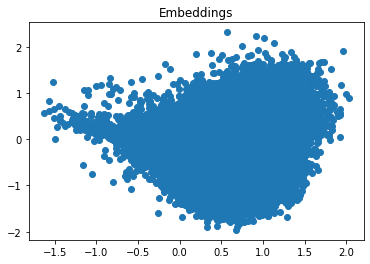

In [154]:
fig, ax = plt.subplots()
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('Embeddings')
plt.show()

I select the words with frequency higher than 200:

In [155]:
print(str(len(vocab)))
selected_words = []
for item in vocab:
   #if model.wv.vocab[item].count > 200:
   if model.wv.get_vecattr(item, "count") > 200:
     selected_words.append(item)
print(str(len(selected_words)))
selected_words[:5]

89895
1215


['I', 'one', 'much', 'would', 'The']

Annotated the plot with the words:

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9002 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9001 missing from current font.
  font.set_text(s, 0.0, flags=flags)


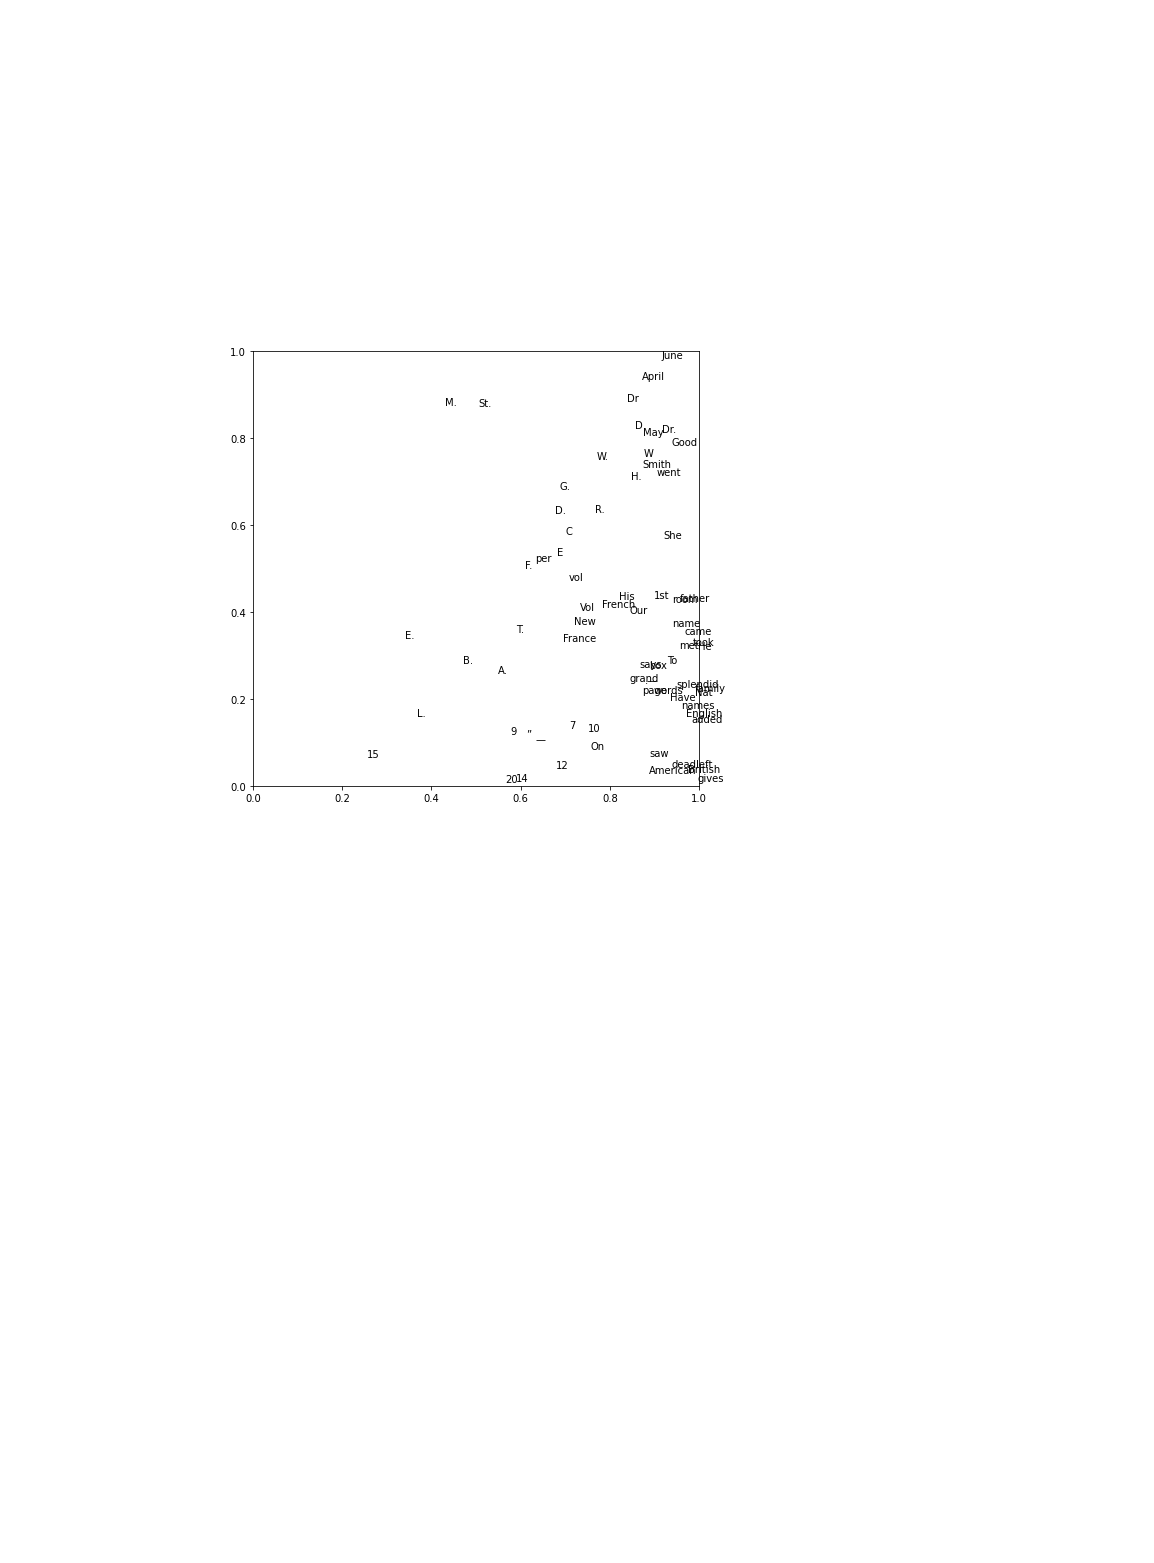

In [156]:
plt.figure(figsize=(8,8))
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('Embeddings of words with freq > 200')
for i, word in enumerate(selected_words):
  plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

For a better visualisation, I first apply PCA:

In [157]:
pca50 = PCA(n_components=50)
result50 = pca50.fit_transform(X)

Then t-sne. **This can take several minutes. You can skip this cell.**

In [158]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(result50)
np.save(os.path.join(models_folder, 'tsne.npy'), tsne_results) 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 89895 samples in 1.181s...
[t-SNE] Computed neighbors for 89895 samples in 851.838s...
[t-SNE] Computed conditional probabilities for sample 1000 / 89895
[t-SNE] Computed conditional probabilities for sample 2000 / 89895
[t-SNE] Computed conditional probabilities for sample 3000 / 89895
[t-SNE] Computed conditional probabilities for sample 4000 / 89895
[t-SNE] Computed conditional probabilities for sample 5000 / 89895
[t-SNE] Computed conditional probabilities for sample 6000 / 89895
[t-SNE] Computed conditional probabilities for sample 7000 / 89895
[t-SNE] Computed conditional probabilities for sample 8000 / 89895
[t-SNE] Computed conditional probabilities for sample 9000 / 89895
[t-SNE] Computed conditional probabilities for sample 10000 / 89895
[t-SNE] Computed conditional probabilities for sample 11000 / 89895
[t-SNE] Computed conditional probabilities for sample 12000 / 89895
[t-SNE] Computed conditional probabilities for 

Load t-sne model:

In [159]:
tsne_results = np.load(os.path.join(models_folder, 'tsne.npy'))

Visualise:

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9002 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9002 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9001 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9001 missing from current font.
  font.set_text(s, 0, flags=flags)


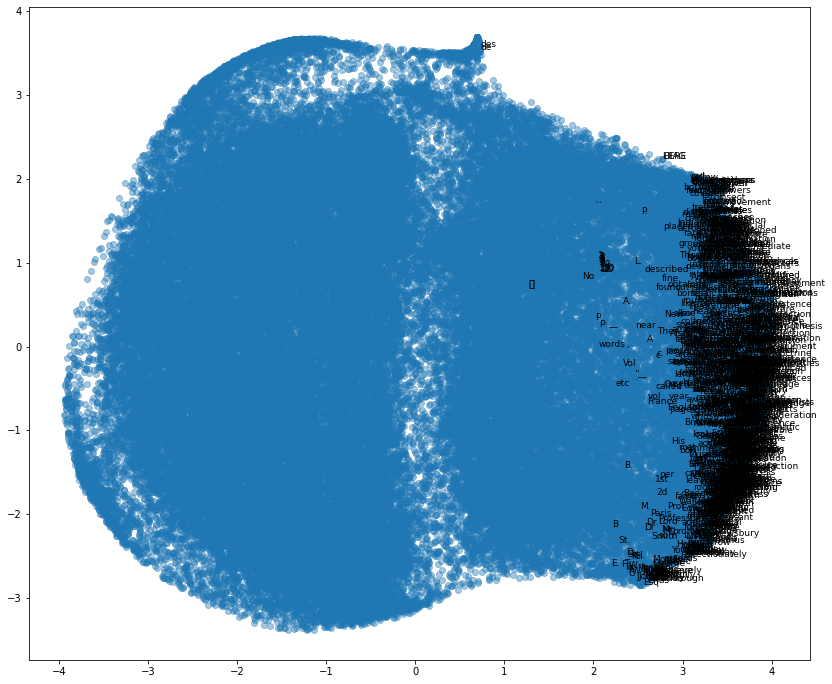

In [160]:
plots_folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Files/Plots'
if not os.path.exists(plots_folder):
  os.makedirs(plots_folder)

plt.figure(figsize=(14,12))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.4)
for i, token in enumerate(selected_words):
  plt.annotate(token, xy=(tsne_results[i, 0], tsne_results[i, 1]), fontsize=9)
#plt.show()
# save figure to file:
plt.savefig(os.path.join(plots_folder, "Selected_words.png"))

I now display only the  scientific terms:

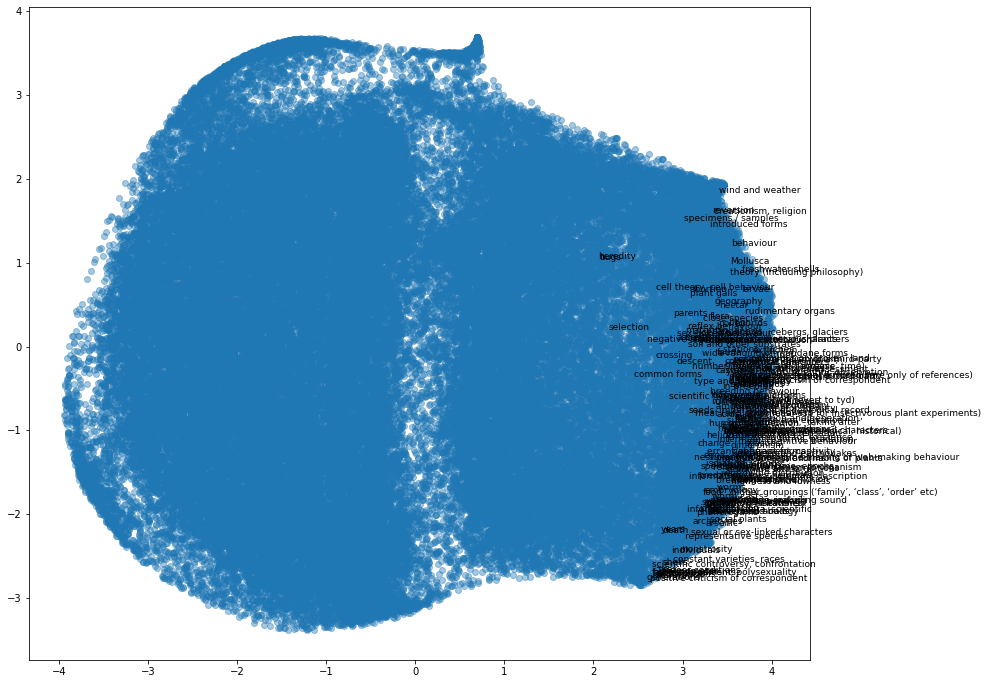

In [161]:
plt.figure(figsize=(14,12))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.4)
for i, token in enumerate(scientific_terms):
  plt.annotate(token, xy=(tsne_results[i, 0], tsne_results[i, 1]), fontsize=9)
#plt.show()
plt.savefig(os.path.join(plots_folder, "Scientific_terms.png"))

# Tuesday 15 June 2021: afternoon session


In the rest of this notebook we will automatically detect the lexical semantic change of the terms in the Darwin corpus.

## Step 1: Define two time periods and split the corpus

In [47]:
time_period_1 = list(range(min(df['Year']),1859+1))
time_period_2 = list(range(1860,max(df['Year'])+1))

### Create two subcorpora

In [162]:
df1 = df[df['Year'].isin(time_period_1)]
df1.shape[0]

2372

In [163]:
df2 = df[df['Year'].isin(time_period_2)]
df2.shape[0]

6535

Check that I haven't lost any line:

In [164]:
df.shape[0] == df1.shape[0] + df2.shape[0]

True

## Step 2. Train word embeddings for the two time periods



I train two word2vec models, one for each dataframe corresponding to a time period. This takes approximately 5 minutes. **You can skip this cell.**

In [165]:
model1 = gensim.models.Word2Vec(df1['Tokens_nostop'], min_count=0, vector_size=300, window = 10, sg = 1)
model2 = gensim.models.Word2Vec(df2['Tokens_nostop'], min_count=0, vector_size=300, window = 10, sg = 1)

Save the models. **You can skip this cell.**

In [166]:
models_folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Models'
models = [model1, model2]
models_names = ["model1", "model2"]
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

Saving model number 1
Saving model number 2


Function for printing the vocabulary of a model

In [167]:
def print_vocab(model, top_n = None):
  count = 0
  if top_n is not None:
    for index, word in enumerate(model.wv.index_to_key):
      count+= 1
      if count < top_n:
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
  else:
    for index, word in enumerate(model.wv.index_to_key):
      print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

I load the models:

In [168]:
models_folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Models'
model1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model1"))
model2 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model2"))
models = [model1, model2]
models_names = ["model1", "model2"]

What are the vocabularies of these models?

In [169]:
print_vocab(model1, 10)

word #0/44155 is I
word #1/44155 is much
word #2/44155 is one
word #3/44155 is would
word #4/44155 is think
word #5/44155 is The
word #6/44155 is species
word #7/44155 is dear
word #8/44155 is shall


In [170]:
print_vocab(model2, 10)

word #0/69946 is I
word #1/69946 is one
word #2/69946 is much
word #3/69946 is The
word #4/69946 is would
word #5/69946 is ”
word #6/69946 is Darwin
word #7/69946 is think
word #8/69946 is may


In [171]:
print(str(len(list(model.wv.index_to_key))))
print(str(len(list(model1.wv.index_to_key))))
print(str(len(list(model2.wv.index_to_key))))

89895
44155
69946


The intersection between the vocabularies of the two models:

In [172]:
vocab1 = set(list(model1.wv.index_to_key))
vocab2 = set(list(model2.wv.index_to_key))
len(vocab1.intersection(vocab2))

24206

## Step 3. Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords <https://github.com/williamleif/histwords>.

First, I define a function to find the intersection between the vocabularies of two word2vec models:

In [173]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

Then, I define a function for aligning two spaces with [Orthogonal Procrustes](https://simonensemble.github.io/2018-10/orthogonal-procrustes.html):

In [174]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

Now I can apply the function to my models:

In [175]:
smart_procrustes_align_gensim(model1, model2, words=None)

24206 24206
24206 24206


Now the two models have been aligned and have the same vocabulary:

In [176]:
len(model1.wv.index_to_key)

24206

In [177]:
len(model2.wv.index_to_key)

24206

In [178]:
model1.wv.index_to_key == model2.wv.index_to_key

True

I print the vocabulary:

In [179]:
model1.wv.index_to_key

['I',
 'one',
 'much',
 'would',
 'The',
 'think',
 'Darwin',
 '”',
 'shall',
 'may',
 'time',
 'see',
 'species',
 'know',
 'good',
 'must',
 'great',
 'My',
 'dear',
 'It',
 'two',
 'letter',
 'Yours',
 'like',
 'many',
 'little',
 'say',
 'could',
 'hope',
 'send',
 'work',
 'Sir',
 'believe',
 'well',
 'C.',
 'quite',
 'whether',
 'You',
 'long',
 'last',
 'case',
 'give',
 'But',
 'If',
 'In',
 'find',
 'sincerely',
 'hear',
 '—',
 'first',
 'Mr',
 'read',
 'plants',
 'also',
 'make',
 'never',
 'kind',
 'shd',
 'write',
 'get',
 'made',
 'new',
 'man',
 'Your',
 'come',
 'book',
 'old',
 'found',
 'glad',
 'sent',
 'subject',
 'far',
 'ever',
 'yet',
 'though',
 'paper',
 'take',
 'seems',
 'day',
 'thanks',
 'go',
 'wish',
 'way',
 'thought',
 '2',
 'obliged',
 'seen',
 'might',
 'c',
 'note',
 'even',
 'wd',
 'With',
 'present',
 'tell',
 'We',
 'years',
 'truly',
 'part',
 'rather',
 'without',
 'He',
 'Hooker',
 'better',
 'always',
 'every',
 'Ch',
 'Mr.',
 'This',
 'suppose

I save the aligned models:

In [180]:
for i in range(len(models)):
  print(models_names[i])
  models[i].save(os.path.join(models_folder, models_names[i] + "_aligned"))

model1
model2


Let's look at the similarity between two words in the two spaces:

In [182]:
model1.wv.similarity("letter", "note")

0.81676626

In [183]:
model2.wv.similarity("letter", "note")

0.77575904

## Step 4: Measure change

Now I can measure the cosine similarity between the embedding of a word in the first time period and the embedding of the same word in the second time period. 

Let's take the word *letter*:

These are the frequency counts of *letter* in the two subcorpora:

In [233]:
model1.wv.get_vecattr("letter", "count")  

1482

In [234]:
model2.wv.get_vecattr("letter", "count") 

2594

And these are its vectors:

In [184]:
vec_letter1 = model1.wv['letter']
vec_letter2 = model2.wv['letter']

NameError: ignored

This is the cosine similarity between the two vectors of *letter*:

In [186]:
spatial.distance.cosine(vec_letter1, vec_letter2)

0.1439102292060852

The cosine distance is 1 - cosine similarity, which we can interpret as the **semantic change** for this word:

In [187]:
1-spatial.distance.cosine(vec_letter1, vec_letter2)

0.8560897707939148

Semantic change of *species*:

In [188]:
1-spatial.distance.cosine(model1.wv['species'], model2.wv['species'])

0.845694899559021

Semantic change of *history*:

In [189]:
1-spatial.distance.cosine(model1.wv['history'], model2.wv['history'])

0.8228279948234558

Let's define a function that calculates the semantic change of a word:

In [218]:
def semantic_change(word):
  sc = 1-spatial.distance.cosine(model1.wv[word], model2.wv[word])
  return sc

Now I calculate the semantic change for all words in the vocabulary, and store this in the dataframe semantic_change; I also add a column for the frequency of the word in the first space and another one for its frequency in the second space:

In [235]:
semantic_change.df = pd.DataFrame(([w, semantic_change(w), model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in model1.wv.index_to_key), columns = ('Word', 'Semantic_change', "Frequency_t1", "Frequency_t2"))
semantic_change.df

,Word,Semantic_change,Frequency_t1,Frequency_t2
0,I,0.923117,35971,65776
1,one,0.865973,3455,6101
2,much,0.884657,3300,5908
3,would,0.872155,2967,5699
4,The,0.864300,2780,5405
...,...,...,...,...
24201,Daubeny.—,0.962092,1,2
24202,—12,0.960387,1,2
24203,having.—,0.959258,1,2
24204,borings,0.965136,1,2


Visualise the distribution of the semantic change scores with a histogram:

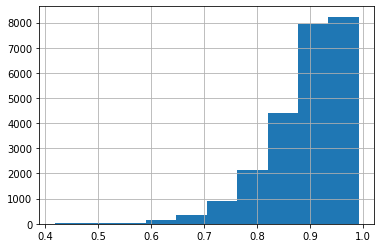

In [237]:
hist = semantic_change.df['Semantic_change'].hist()

Now I sort by decreasing semantic change score:

In [238]:
semantic_change.df.sorted = semantic_change.df.sort_values(by='Semantic_change', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


I save this to a file:

In [250]:
output_folder = '/gdrive/My Drive/2021/CDH-Semantic-change-Darwin-course_BMcGillivray/Output'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
semantic_change.df.sorted.to_csv(os.path.join(output_folder, 'semantic_change_all_words.csv'), encoding='utf-8')

The top most changed words:

In [251]:
semantic_change.df.sorted.head(100)

,Word,Semantic_change,Frequency_t1,Frequency_t2
18741,Indo-Chinese,0.991854,2,3
22481,Verbena,0.991470,1,3
23967,papilla,0.990552,1,2
24192,381,0.990022,1,2
19800,inlets,0.989829,2,3
...,...,...,...,...
23030,acid.,0.984006,1,2
18395,Gloucester,0.983917,2,3
19227,broach,0.983915,2,3
19048,No.2,0.983890,2,3


I add the total frequency:

In [253]:
semantic_change.df.sorted["Total_Frequency"] = semantic_change.df.sorted["Frequency_t1"]+semantic_change.df.sorted["Frequency_t2"]
semantic_change.df.sorted

,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency
18741,Indo-Chinese,0.991854,2,3,5
22481,Verbena,0.991470,1,3,4
23967,papilla,0.990552,1,2,3
24192,381,0.990022,1,2,3
19800,inlets,0.989829,2,3,5
...,...,...,...,...,...
5690,5000,0.442542,10,20,30
4443,1500,0.435484,15,28,43
4056,Max,0.424096,17,32,49
3320,gay,0.423741,22,41,63


I plot the terms by their total frequency and semantic change score:

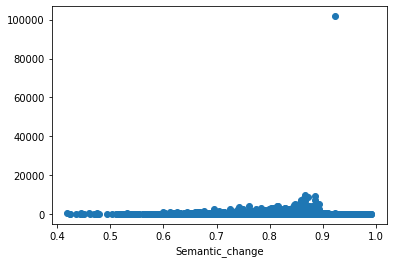

In [254]:
ax = semantic_change.df.sorted.set_index('Semantic_change')['Total_Frequency'].plot(style='o')

Which word is the outlier?

In [298]:
semantic_change.df.sorted.loc[semantic_change.df.sorted['Total_Frequency'] > 80000].Word.tolist()

['I']

I exclude "I":

In [301]:
semantic_change.df.sorted1 = semantic_change.df.sorted.loc[semantic_change.df.sorted['Total_Frequency'] < 80000]
semantic_change.df.sorted1.shape

(24205, 5)

Now I focus on those words that have a frequency higher than 100 and a semantic change score above 0.9. How many are there?

In [311]:
semantic_change.df.sorted.filtered = semantic_change.df.sorted1.loc[(semantic_change.df.sorted['Total_Frequency'] > 100) & (semantic_change.df.sorted['Semantic_change'] > 0.9)]
semantic_change.df.sorted.filtered.shape

(104, 5)

Which words are these words?*italicised text*

In [310]:
semantic_change.df.sorted.filtered

,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency
2073,oclock,0.939105,39,73,112
1912,earnestly,0.934561,43,81,124
1729,Esqr,0.934287,48,91,139
1788,plans,0.932637,46,87,133
1930,idle,0.931795,42,81,123
...,...,...,...,...,...
1516,distant,0.901379,55,103,158
2108,related,0.901176,38,71,109
2126,advanced,0.901139,38,71,109
2177,foolish,0.900999,37,68,105


I create a list for these words:

In [315]:
highfreq_highlychanged_words = semantic_change.df.sorted.filtered.Word.tolist()
highfreq_highlychanged_words

['oclock',
 'earnestly',
 'Esqr',
 'plans',
 'idle',
 'affectionate',
 'unwell',
 'advise',
 'happiness',
 'oblige',
 'well.—',
 'vegetation',
 'criticisms',
 'migration',
 'gratified',
 'Books',
 'Emma',
 'continued',
 'geographical',
 'comfort',
 'forming',
 'enjoy',
 'classification',
 'invitation',
 'scale',
 'hoped',
 'suit',
 'fault',
 'delightful',
 'Southern',
 'Esqre',
 'press',
 'confess',
 'remembrances',
 'delayed',
 'stop',
 'collect',
 'unreasonable',
 'decide',
 'gladly',
 'ignorance',
 'talked',
 'spoke',
 'independent',
 'time.—',
 'obedient',
 'Though',
 'intention',
 'Friday',
 'woodcuts',
 'assistance',
 'Nov.',
 'river',
 'hearty',
 'him.—',
 'advice',
 'stronger',
 'conclusions',
 'subject.—',
 'hurry',
 'prefer',
 'interests',
 'domesticated',
 'ready',
 'request',
 'office',
 'alluded',
 'Catherine',
 'Post',
 'seldom',
 'modification',
 'permission',
 'tomorrow',
 'varying',
 'filled',
 'willing',
 'consult',
 'stay',
 'absolute',
 'enquire',
 'worse',
 'settle

Now I annotate the plot with these:

w oclock
sc: 0.9391046166419983
f: 112
w earnestly
sc: 0.9345610737800598
f: 124
w Esqr
sc: 0.9342868328094482
f: 139
w plans
sc: 0.9326371550559998
f: 133
w idle
sc: 0.931795060634613
f: 123
w affectionate
sc: 0.9303210377693176
f: 195
w unwell
sc: 0.930208146572113
f: 150
w advise
sc: 0.9291574954986572
f: 123
w happiness
sc: 0.9289718270301819
f: 125
w oblige
sc: 0.9284200072288513
f: 176
w well.—
sc: 0.9275076389312744
f: 119
w vegetation
sc: 0.9273537397384644
f: 148
w criticisms
sc: 0.9272754192352295
f: 127
w migration
sc: 0.9248253703117371
f: 125
w gratified
sc: 0.9244080185890198
f: 111
w Books
sc: 0.9241964817047119
f: 140
w Emma
sc: 0.9235418438911438
f: 296
w continued
sc: 0.9232272505760193
f: 160
w geographical
sc: 0.9217125773429871
f: 107
w comfort
sc: 0.9212564826011658
f: 144
w forming
sc: 0.920544445514679
f: 103
w enjoy
sc: 0.9204869866371155
f: 255
w classification
sc: 0.9203577637672424
f: 119
w invitation
sc: 0.919963002204895
f: 116
w scale
sc: 0.91987586021423

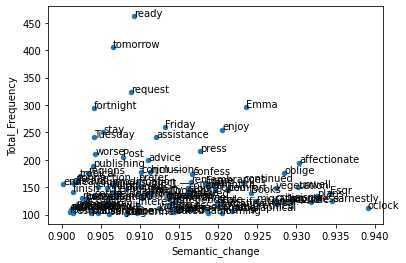

In [314]:
semantic_change.df.sorted.filtered.p = semantic_change.df.sorted.filtered[['Word','Semantic_change', 'Total_Frequency']]
fig, ax = plt.subplots()
semantic_change.df.sorted.filtered.p.plot('Semantic_change', 'Total_Frequency', kind='scatter', ax=ax)
for k, v in semantic_change.df.sorted.filtered.p.iterrows():
  word = v['Word']
  sc = v['Semantic_change']
  f = v['Total_Frequency']
  print("w", v['Word'])
  print("sc:", str(sc))
  print("f:", str(f))
  ax.annotate(word, xy=(sc,f))

What are the neighbours of these words in the two spaces?

In [316]:
for word in highfreq_highlychanged_words:
  print(word)
  print("Neighbours in first space:")
  print(model1.wv.similar_by_word(word, 10))
  print("Neighbours in second space:")
  print(model2.wv.similar_by_word(word, 10))

oclock
Neighbours in first space:
[('clock', 0.9219688773155212), ('Train', 0.9119281768798828), ('Croydon', 0.9073127508163452), ('Station', 0.9026201367378235), ('hour.—', 0.8991454243659973), ('Beckenham', 0.8991335034370422), ('Sydenham', 0.8968976736068726), ('phaeton', 0.8961048722267151), ('Fly', 0.8960550427436829), ('4o', 0.8959371447563171)]
Neighbours in second space:
[('10o', 0.9348551034927368), ('clock', 0.9342089891433716), ('912', 0.9296838045120239), ('breakfast', 0.9277592897415161), ('Train', 0.9238875508308411), ('oclock.—', 0.9154780507087708), ('Hartfield', 0.9094255566596985), ('1o', 0.9085496664047241), ('carriage', 0.9068554043769836), ('P.M.', 0.9048059582710266)]
earnestly
Neighbours in first space:
[('shorten', 0.9405455589294434), ('suggestions', 0.9357426166534424), ('undertake', 0.9353176951408386), ('grant', 0.934542715549469), ('continue', 0.9343862533569336), ('appointment', 0.9331748485565186), ('patience', 0.9317224025726318), ('trouble.—', 0.9308561

I print this to an output file:

In [317]:
outfile = open(os.path.join(output_folder, 'Neighbours_changed_words.csv'), 'w+')
output_writer = csv.writer(outfile, delimiter = "\t")

# Write header row:
output_writer.writerow(["Word", "Neighbours_first_space", "Neighbours_second_space"]) 
for word in highfreq_highlychanged_words:
  print(word)
  print("Neighbours in first space:")
  print(model1.wv.similar_by_word(word, 10))
  print("Neighbours in second space:")
  print(model2.wv.similar_by_word(word, 10))
  output_writer.writerow([word, model1.wv.similar_by_word(word, 10), model2.wv.similar_by_word(word, 10)]) 
outfile.close()

oclock
Neighbours in first space:
[('clock', 0.9219688773155212), ('Train', 0.9119281768798828), ('Croydon', 0.9073127508163452), ('Station', 0.9026201367378235), ('hour.—', 0.8991454243659973), ('Beckenham', 0.8991335034370422), ('Sydenham', 0.8968976736068726), ('phaeton', 0.8961048722267151), ('Fly', 0.8960550427436829), ('4o', 0.8959371447563171)]
Neighbours in second space:
[('10o', 0.9348551034927368), ('clock', 0.9342089891433716), ('912', 0.9296838045120239), ('breakfast', 0.9277592897415161), ('Train', 0.9238875508308411), ('oclock.—', 0.9154780507087708), ('Hartfield', 0.9094255566596985), ('1o', 0.9085496664047241), ('carriage', 0.9068554043769836), ('P.M.', 0.9048059582710266)]
earnestly
Neighbours in first space:
[('shorten', 0.9405455589294434), ('suggestions', 0.9357426166534424), ('undertake', 0.9353176951408386), ('grant', 0.934542715549469), ('continue', 0.9343862533569336), ('appointment', 0.9331748485565186), ('patience', 0.9317224025726318), ('trouble.—', 0.9308561